# 1D Burgers Discovery Numerical

*2024-04-21*

This work is based on:

* *STLSQ* - Sequentially thresholded least squares regression algorithm. Attempts to minimize the objective function by iteratively performing least squares and masking out elements of the weight that are below a given threshold.
* *PySINDy* - [Sparse regression package](<https://pysindy.readthedocs.io/en/latest/examples/10_PDEFIND_examples/example.html#Test-PDE-functionality-on-Burgers'-equation>) with several implementations for the Sparse Identification of Nonlinear Dynamical systems (SINDy) method introduced in Brunton et al. (2016)

In [22]:
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pysindy as ps
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
import warnings
import numpy as np
# Seed for reproducibility
np.random.seed(1000)
# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Dataset # 1

From the PySindy example:

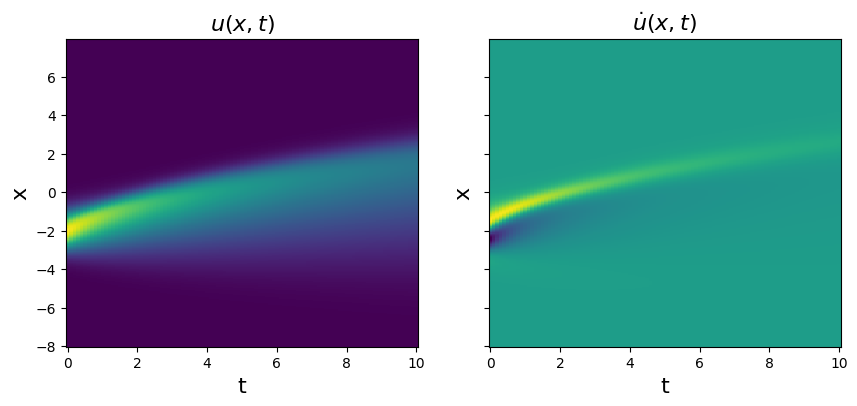

In [18]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

### Solve the equation (inverse problem)

In [20]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                 feature_names=["u", "t"])
model.fit(u, t=dt)
model.print()

STLSQ model: 
(u)' = 0.100 u_11 + -1.001 uu_1


The original equation is $u_t = 0.1 u_{xx} - uu_x$

$\displaystyle \frac{\partial u}{\partial t} = 0.1 \frac{\partial^2u}{\partial x^2} - u \frac{\partial u}{\partial x}$

The differential operator parameter $\lambda_1$ (or $u$) is the speed of fluid at the indicated spatial and temporal coordinates, the differential operator parameter $\lambda_2$ (or $\nu$) is the kinematic viscosity of fluid, and the subscripts denote partial differentiation in time and space, respectively, as
$u_t$ (which denotes $\frac{du}{dt}$), 
$u_x$ (which denotes $\frac{du}{dx}$), and 
$u_{xx}$ (which denotes $\frac{d^2u}{dx^2}$).

## Dataset # 2

From the Raissi article.

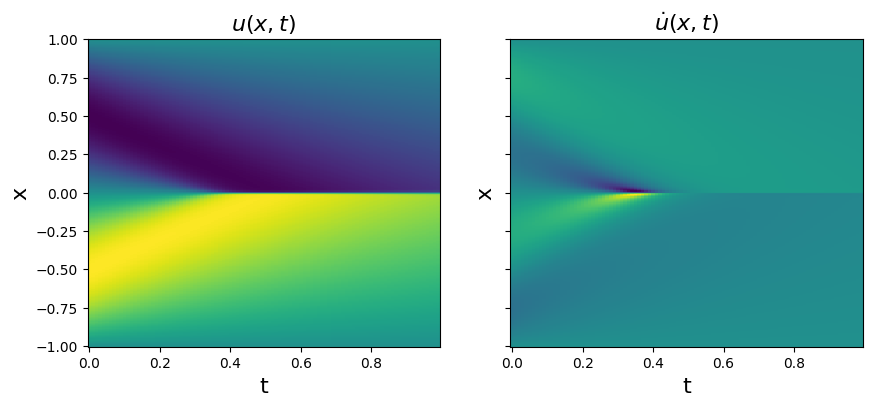

In [23]:
# Load data from .mat file
data = loadmat('../direto/data/burgers_shock.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

### Solve the equation (inverse problem)

In [25]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual",
                   normalize_columns=True,
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,
                feature_names=["u"])
model.fit(u, t=dt)
model.print()

STLSQ model: 
(u)' = 0.004 u_11 + -1.008 uu_1 + 0.001 uuu_11
SR3 model, L0 norm: 
(u)' = 0.004 u_11 + -1.008 uu_1 + 0.001 uuu_11
SR3 model, L1 norm: 
(u)' = 0.004 u_11 + -1.008 uu_1 + 0.001 uuu_11
SSR model: 
(u)' = 0.011 u + 0.004 u_11 + -1.011 uu_1 + 0.001 uuu_11
SSR (metric = model residual) model: 
(u)' = 0.011 u + 0.004 u_11 + -1.011 uu_1 + 0.001 uuu_11
FROLs model: 
(u)' = 0.015 u + 0.004 u_11 + -1.002 uu_1


The original Burgers equation is

$$
\displaystyle \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}
$$

for -1.0 < $x$ < +1.0

and $t$ > 0

Initial conditions are $u(x, 0) = - \sin(\pi x)$

Boundary conditions are $u(-1, t) = u(+1, t) = 0$

The viscosity parameter $\nu$ is taken to be $\frac{0.01}{\pi} = 0.003183$

## References

Brunton, S. L., Proctor, J. L., & Kutz, J. N. (2016). Discovering governing equations from data by sparse identification of nonlinear dynamical systems. Proceedings of the National Academy of Sciences, 113(15), 3932–3937. https://doi.org/10.1073/pnas.1517384113